[View in Colaboratory](https://colab.research.google.com/github/sl2820/Deep_Learning_Study/blob/master/Classification_with_Custom_Dataset.ipynb)

In [0]:
import os


In [2]:
here = os.getcwd()
print(here)

/content


In [3]:
!ls

custom_data_bw.npz  custom_data_color.npz  sample_data


In [0]:
#cd /content/data

In [5]:
here = os.getcwd()
print(here)

/content


In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
print ("Current TF version is %s" % tf.__version__)
print ("Packages Loaded")

Current TF version is 1.11.0-rc2
Packages Loaded


In [11]:
# LOAD DATA
cwd = os.getcwd()
loadpath = cwd + "/custom_data_color.npz"  # for color
#loadpath = cwd + "/custom_data_bw.npz" # for Black and White

l = np.load(loadpath)
print (l.files)

# PARSE LOADED DATA
trainimg = l['trainimg']
trainlabel = l['trainlabel']
testimg = l['testimg']
testlabel = l['testlabel']
imgsize = l['imgsize']
categories = l['categories']
use_gray = l['use_gray']
if use_gray:
    nimgch = 1
else:
    nimgch = 3
ntrain = trainimg.shape[0]
nclass = trainlabel.shape[1]
dim = trainimg.shape[1]
ntest = testimg.shape[0]
print ("%d TRAIN IMAGES" % (ntrain))
print ("%d TEST IMAGES" % (ntest))
print ("%d DIMENSIONAL INPUT" % (dim))   # 64 x 64 images
print ("%d CLASSES" % (nclass))
print (imgsize)
print (categories)


['trainimg', 'trainlabel', 'testimg', 'testlabel', 'imgsize', 'use_gray', 'categories']
660 TRAIN IMAGES
165 TEST IMAGES
12288 DIMENSIONAL INPUT
5 CLASSES
[64 64]
['Terminator' 'Koizumi' 'Putin' 'Bush' 'Blair']


In [12]:
# NETWORK TOPOLOCIES
n_input = dim # 64 x 64 images
n_channel = 64
n_classes = nclass

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# NETWORK PARAMETERS
stddev = 0.1
weights = {
    'c1' : tf.Variable(tf.random_normal([7, 7, nimgch, n_channel], stddev=stddev)),
    'd1' : tf.Variable(tf.random_normal([n_channel*imgsize[0]*imgsize[1]//4, n_classes], stddev=stddev))
}
biases = {
    'c1' : tf.Variable(tf.random_normal([n_channel], stddev=stddev)),
    'd1' : tf.Variable(tf.random_normal([n_classes], stddev=stddev))
}
print ("NETWORK READY")

NETWORK READY


In [13]:
# Model
def CNN(_x, _w, _b):
    # Reshape
    _x_r = tf.reshape (_x, shape = [-1, imgsize[0], imgsize[1], nimgch])  # 우리 리사이즈에 맞춰서 imgsize[0] x imgsize[1]으로
    # Convolution
    _conv1 = tf.nn.conv2d(_x_r, _w['c1'], strides=[1,1,1,1], padding='SAME')
    # Add Biase
    _conv2 = tf.nn.bias_add(_conv1, _b['c1'])
    # ReLU
    _conv3 = tf.nn.relu(_conv2)
    # Max Pool
    _pool = tf.nn.max_pool(_conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    #Vectorize
    _dense = tf.reshape(_pool, [-1, _w['d1'].get_shape().as_list()[0]])
    # Dense
    _logit = tf.add(tf.matmul(_dense, _w['d1']), _b['d1'])
    _out = {
        'x_r': _x_r,
        'conv1': _conv1,
        'conv2': _conv2,
        'conv3': _conv3,
        'pool': _pool,
        'dense': _dense,
        'logit': _logit
    }
    return _out

#Prediction
cnnout = CNN(x, weights, biases)

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=cnnout['logit']))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
corr = tf.equal(tf.argmax(cnnout['logit'],1), tf.argmax(y,1))
accr = tf.reduce_mean(tf.cast(corr, 'float'))

#Initializer
init = tf.global_variables_initializer()
print ("Functions Ready")

Functions Ready


Epoch: 002/010 cost : 4.418508967
 TRAIN ACCURACY : 0.370
TEST ACCURACY : 0.358
106 MISSED


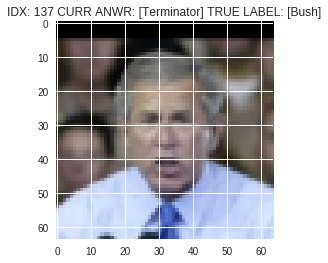

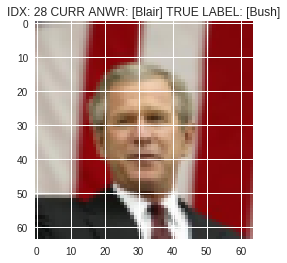

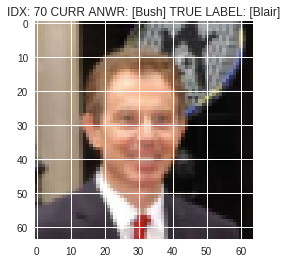

Epoch: 004/010 cost : 2.177290380
 TRAIN ACCURACY : 0.620
TEST ACCURACY : 0.600
66 MISSED


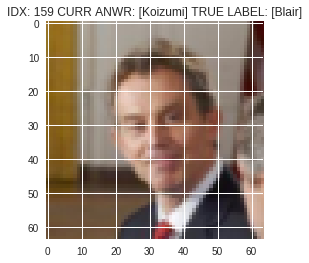

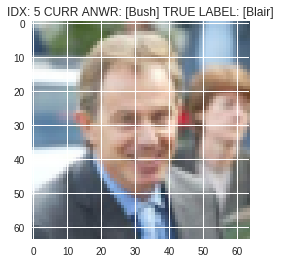

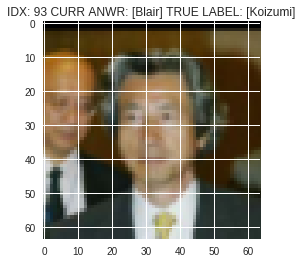

Epoch: 006/010 cost : 0.945808788
 TRAIN ACCURACY : 0.730
TEST ACCURACY : 0.624
62 MISSED


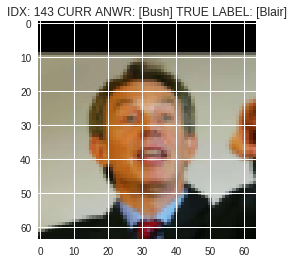

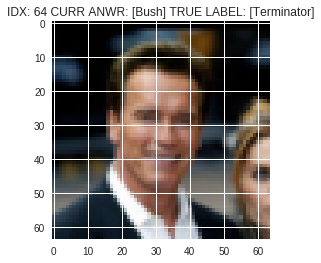

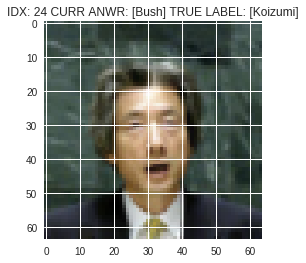

Epoch: 008/010 cost : 0.570728933
 TRAIN ACCURACY : 0.880
TEST ACCURACY : 0.715
47 MISSED


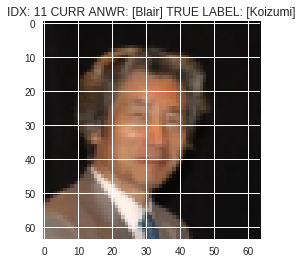

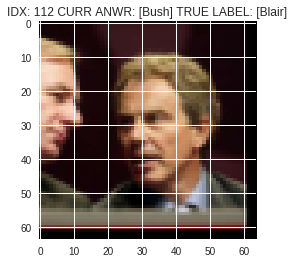

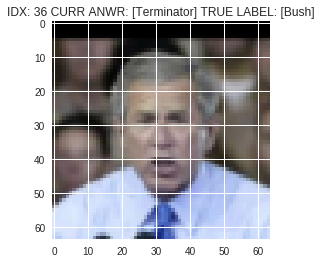

Epoch: 010/010 cost : 0.336903865
 TRAIN ACCURACY : 0.920
TEST ACCURACY : 0.800
33 MISSED


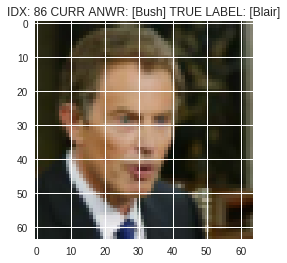

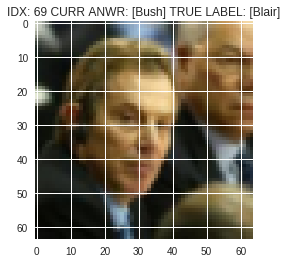

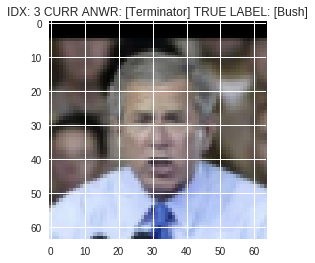

Optimization Finished


In [14]:
# Parameters
training_epochs = 10
batch_size = 100
disp_each = 2
plot_each = 2

# Launch the Graph
sess = tf.Session()
sess.run(init)

# Optimize
for epoch in range (training_epochs):
    total_batch = int (ntrain/batch_size)
    randpermlist = np.random.permutation(ntrain)
    sun_cost= 0.
    
    # iteration
    for i in range (total_batch):
        randidx = randpermlist[i*batch_size:min((i+1)*batch_size, ntrain-1)]
        batch_xs = trainimg[randidx, :]
        batch_ys = trainlabel[randidx, :]
        feeds = {x: batch_xs, y: batch_ys}
        sess.run(optm, feed_dict = feeds)
        sun_cost += sess.run(cost, feed_dict = feeds)
        
    avg_cost = sun_cost / total_batch
    
    
     # DISPLAY
    if (epoch+1) % disp_each == 0 or epoch == training_epochs-1:
        print ("Epoch: %03d/%03d cost : %.9f" % (epoch+1, training_epochs, avg_cost))
        feeds = {x: batch_xs, y:batch_ys}
        train_acc = sess.run(accr, feed_dict=feeds)
        print (" TRAIN ACCURACY : %.3f" % (train_acc))
        feeds = {x: testimg, y:testlabel}
        test_acc = sess.run(accr, feed_dict=feeds)
        print ("TEST ACCURACY : %.3f" % (test_acc))

    #PLOT
    if (epoch+1) % plot_each == 0 or epoch == training_epochs-1:
        ntemp = int(ntest/batch_size) + 1
        missidxlist = []
        for ii in range(ntemp):
            iii = np.arange(ii*batch_size, min(ntest, (ii+1)*batch_size))
            feeds = {x: testimg[iii, :], y: testlabel[iii, :]}
            missidx = np.where(sess.run(corr, feed_dict=feeds) == 0)[0]
            missidxlist = np.concatenate((missidxlist, iii[missidx]))
        nmiss = len(missidxlist)
        print ("%d MISSED" % (nmiss))
        # PLOT MISSCLASSIFIED (UPTO THREE)
        missidxlist = np.random.permutation(missidxlist.astype(int))
        selmissidx = missidxlist[:min(3, nmiss)].astype(int)
        feeds_miss = {x: testimg[selmissidx, :], y: testlabel[selmissidx, :]}
        pred_miss = sess.run(cnnout['logit'], feed_dict=feeds_miss)
        answ_miss = np.argmax(pred_miss, 1)
        answ_corr = np.argmax(testlabel[selmissidx, :] ,1)
        for idx in range(len(selmissidx)):
            cidx = selmissidx[idx]
            anw = answ_miss[idx]
            ref = answ_corr[idx]
            if use_gray != 0:
                currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1]))
                plt.imshow(currimg, cmap='gray')
            else :
                currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1], -1))
                plt.imshow(currimg)
            anw_category = categories[anw]
            ref_category = categories[ref]
            title_string = ("IDX: %d CURR ANWR: [%s] TRUE LABEL: [%s]"
                    % (cidx, anw_category, ref_category))
            plt.title(title_string)
            plt.show()
            
print("Optimization Finished")